# Analyzing Global Food Wastage: Insights, Trends & Solutions 

UNEP’s Food Waste Index Report 2024 has highlighted that food waste remains a significant detriment to the global economy and a driver of climate change, biodiversity loss and pollution, resulting in an estimated economic loss of $1trn.

In 2022, global food waste reached 1.05 billion tonnes, including inedible parts, averaging 132 kilograms per capita and representing nearly 20% of all available food for consumers. Households accounted for 60% of this waste, followed by food services at 28% and retail at 12%.

In this notebook I am going to analyse [Global Food Wastage 2018-2024](https://www.kaggle.com/datasets/atharvasoundankar/global-food-wastage-dataset-2018-2024/code) dataset, and answer questions like:
* What food category is wasted the most?
* What are the global food wastage trends?
* What countries waste the most?
* What are the economic loss trends?
* and more...

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor

from kagglehub import KaggleDatasetAdapter

file_path = "global_food_wastage_dataset.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "atharvasoundankar/global-food-wastage-dataset-2018-2024",
  file_path
)

C:\Users\Artur\PycharmProjects\veronika_python\datascience_practice\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Artur\AppData\Local\Temp\ipykernel_7072\3273509475.py:23: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [2]:
df.head()

,Country,Year,Food Category,Total Waste (Tons),Economic Loss (Million $),Avg Waste per Capita (Kg),Population (Million),Household Waste (%)
0,Australia,2019,Fruits & Vegetables,19268.63,18686.68,72.69,87.59,53.64
1,Indonesia,2019,Prepared Food,3916.97,4394.48,192.52,1153.99,30.61
2,Germany,2022,Dairy Products,9700.16,8909.16,166.94,1006.11,48.08
3,France,2023,Fruits & Vegetables,46299.69,40551.22,120.19,953.05,31.91
4,France,2023,Beverages,33096.57,36980.82,104.74,1105.47,36.06


In [3]:
df.shape

(5000, 8)

In [4]:
df.columns

Index(['Country', 'Year', 'Food Category', 'Total Waste (Tons)',
       'Economic Loss (Million $)', 'Avg Waste per Capita (Kg)',
       'Population (Million)', 'Household Waste (%)'],
      dtype='object')

Let's rename the columns for better usability

In [5]:
df.columns = (
    df.columns
    .str.lower()                   
    .str.replace(" ", "_")          
    .str.replace(r"[()$]", "", regex=True)  
)
df.columns

Index(['country', 'year', 'food_category', 'total_waste_tons',
       'economic_loss_million_', 'avg_waste_per_capita_kg',
       'population_million', 'household_waste_%'],
      dtype='object')

In [6]:
df.describe()

,year,total_waste_tons,economic_loss_million_,avg_waste_per_capita_kg,population_million,household_waste_%
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2021.015600,25061.780072,25039.703870,109.46397,706.606416,50.060890
std,1.999239,14245.119588,14620.236429,51.93373,402.546464,11.596203
min,2018.000000,502.610000,406.690000,20.09000,11.290000,30.020000
25%,2019.000000,12783.737500,12612.477500,64.05000,350.602500,40.012500
50%,2021.000000,24865.220000,24428.155000,110.08000,713.530000,50.295000
75%,2023.000000,37471.035000,37146.037500,154.52500,1057.255000,60.125000
max,2024.000000,49990.760000,59228.930000,199.97000,1399.970000,70.000000


In [7]:
df.isna().sum()

country                    0
year                       0
food_category              0
total_waste_tons           0
economic_loss_million_     0
avg_waste_per_capita_kg    0
population_million         0
household_waste_%          0
dtype: int64

As we can see, there are no null values in the dataset

### Total Economic Loss and Food Wastage Trend

In [8]:
df_loss = df.groupby(['year'])['economic_loss_million_'].sum() / 1000000
df_loss = df_loss.reset_index()
df_loss.head()

,year,economic_loss_million_
0,2018,17.637993
1,2019,17.605874
2,2020,18.008964
3,2021,18.292911
4,2022,17.050887


In [9]:
df_waste = df.groupby('year')['total_waste_tons'].sum() / 1000000
df_waste = df_waste.reset_index()
df_waste.head()

,year,total_waste_tons
0,2018,17.625291
1,2019,17.527937
2,2020,18.128400
3,2021,18.305243
4,2022,17.107498


Text(0.5, 1.0, 'Total Economic Loss 2018-2024')

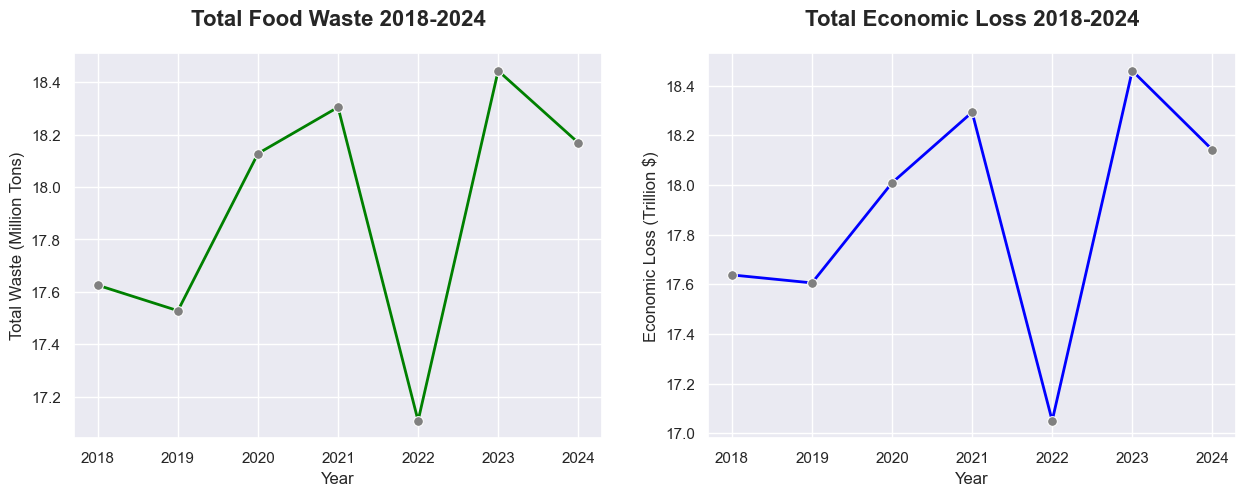

In [10]:
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(df_waste, 
             ax=axes[0], 
             x='year', 
             y='total_waste_tons', 
             color='green', 
             markerfacecolor='grey', 
             markersize=7,
            marker='o', 
             linewidth=2).set(
    xlabel='Year', 
    ylabel='Total Waste (Million Tons)'
)
axes[0].set_title('Total Food Waste 2018-2024', fontsize=16, weight='bold', pad=20)

sns.lineplot(df_loss, 
             ax=axes[1], 
             x='year', 
             y='economic_loss_million_', 
             color='blue', 
             markerfacecolor='grey', 
             markersize=7,
             marker='o', 
             linewidth=2).set(
    xlabel='Year', 
    ylabel='Economic Loss (Trillion $)'
)
axes[1].set_title('Total Economic Loss 2018-2024', fontsize=16, weight='bold', pad=20)

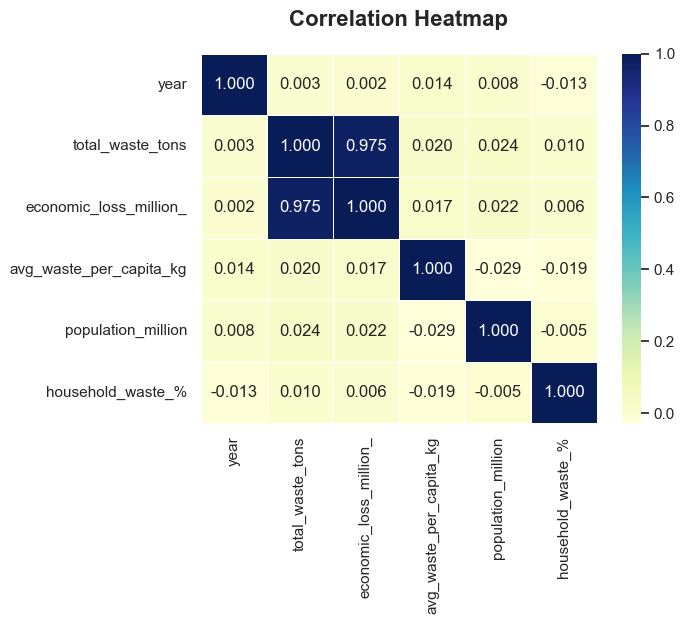

In [11]:
sns.heatmap(
    df.select_dtypes(include='number').corr(), 
    annot=True, 
    cmap='YlGnBu', 
    fmt='.3f', 
    linewidths=0.5
)
plt.title("Correlation Heatmap", fontsize=16, weight='bold', pad=20)
plt.show()

In [12]:
r, p = stats.pearsonr(df['total_waste_tons'], df['economic_loss_million_'])
print(r,p)

0.9745219286512478 0.0


Economic loss and Total waste are very highly correlated and the correlation is statistically significant (low p-value) 
The trend lines on both charts look very similar

Text(0.5, 1.0, 'Relationship between Total Waste and Economic Loss')

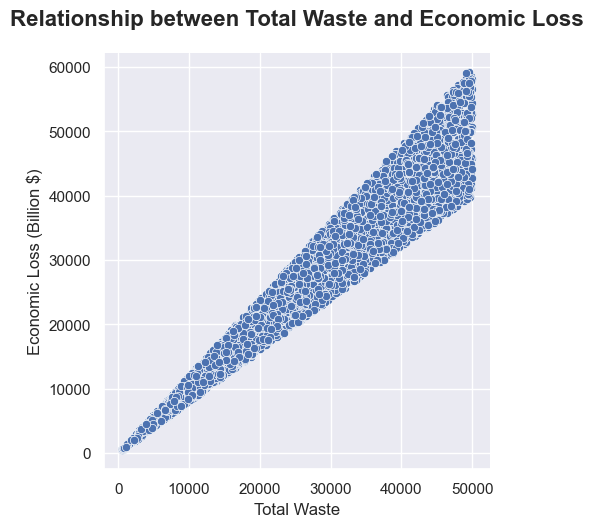

In [13]:
sns.relplot(data=df, x="total_waste_tons", y="economic_loss_million_").set(
    xlabel='Total Waste', 
    ylabel='Economic Loss (Billion $)'
)
plt.title('Relationship between Total Waste and Economic Loss', fontsize=16, weight='bold', pad=20)

### Food Waste Trend

In [14]:
countries= df.country.unique()
europe = ['Germany', 'Spain', 'Russia', 'France', 'Italy', 'UK']
asia = ['India', 'China', 'Turkey', 'Indonesia', 'Japan', 'South Korea']
africa = ['Saudi Arabia', 'South Africa']
s_america = ['Brazil', 'Argentina']
n_america = ['USA', 'Canada', 'Mexico']
australia = ['Australia']
world = {'Africa':africa,'South America':s_america,
         'North America':n_america,'Australia':australia,
        'Europe':europe,'Asia':asia,}

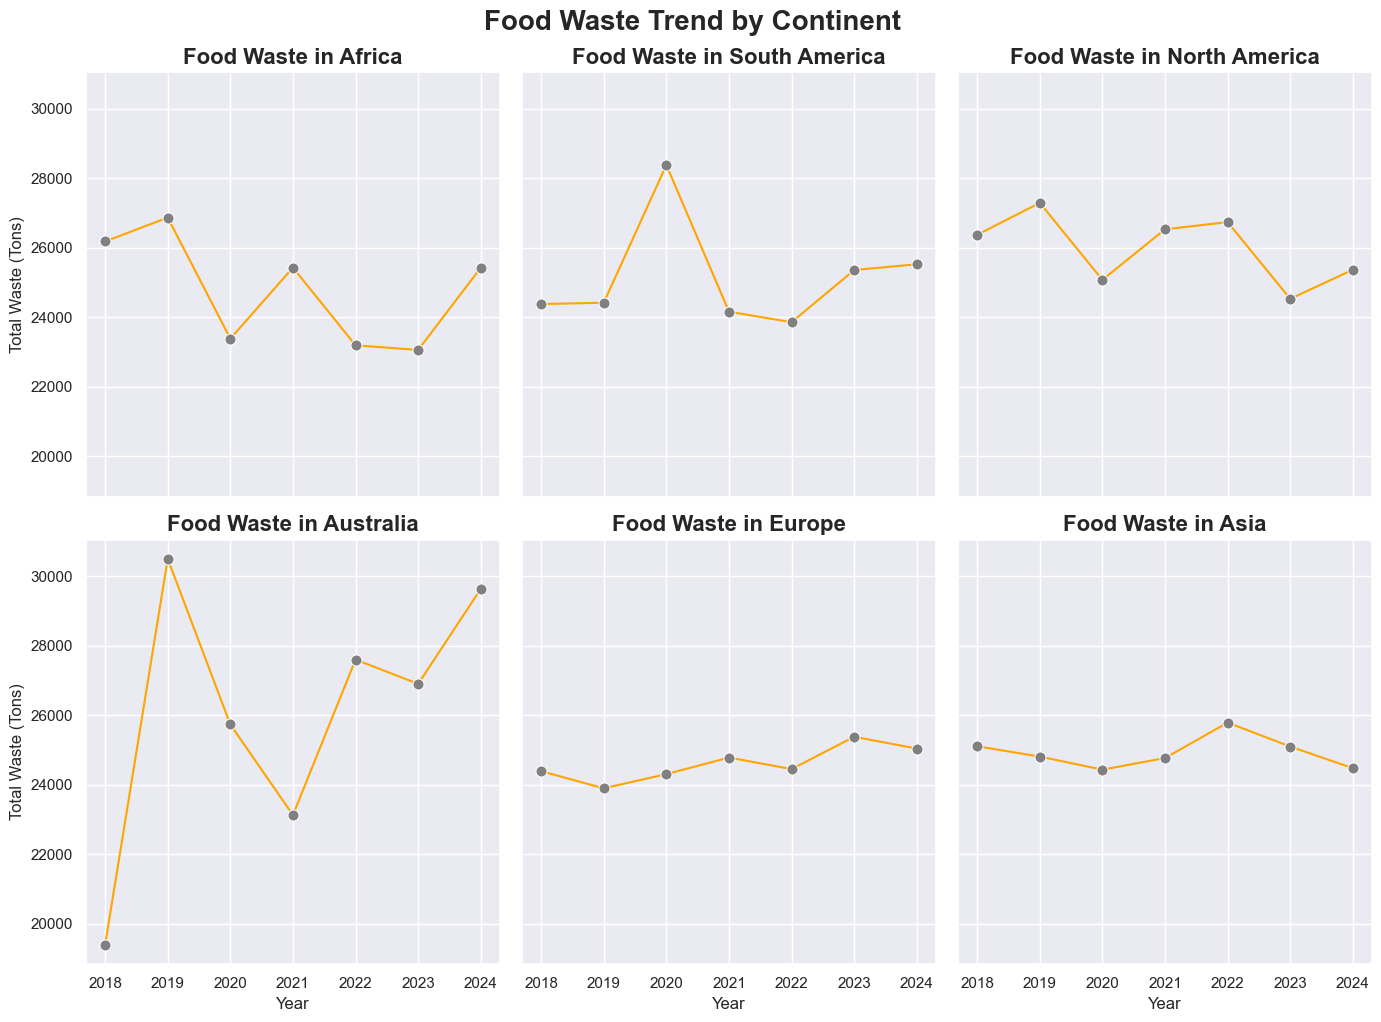

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True)
for ax, continent in zip(axes.flatten(), world.items()):
    sns.lineplot(
        data=df[df['country'].isin(continent[1])],
        x='year',
        y='total_waste_tons',
        marker='o',
        markersize=8,
        color='orange',
        markerfacecolor='grey',
        ax=ax,
        errorbar=None
    )
    ax.set_title(f"Food Waste in {continent[0]}", fontsize=16, weight='bold')
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Waste (Tons)")
    ax.tick_params(axis='x')

plt.tight_layout()
plt.suptitle("Food Waste Trend by Continent", fontsize=20, weight='bold', y=1.02)
plt.show()

From year 2023 till 2024 Food Wastage rose in South and North America, Australia and Africa, but dropped in Europe and Asia

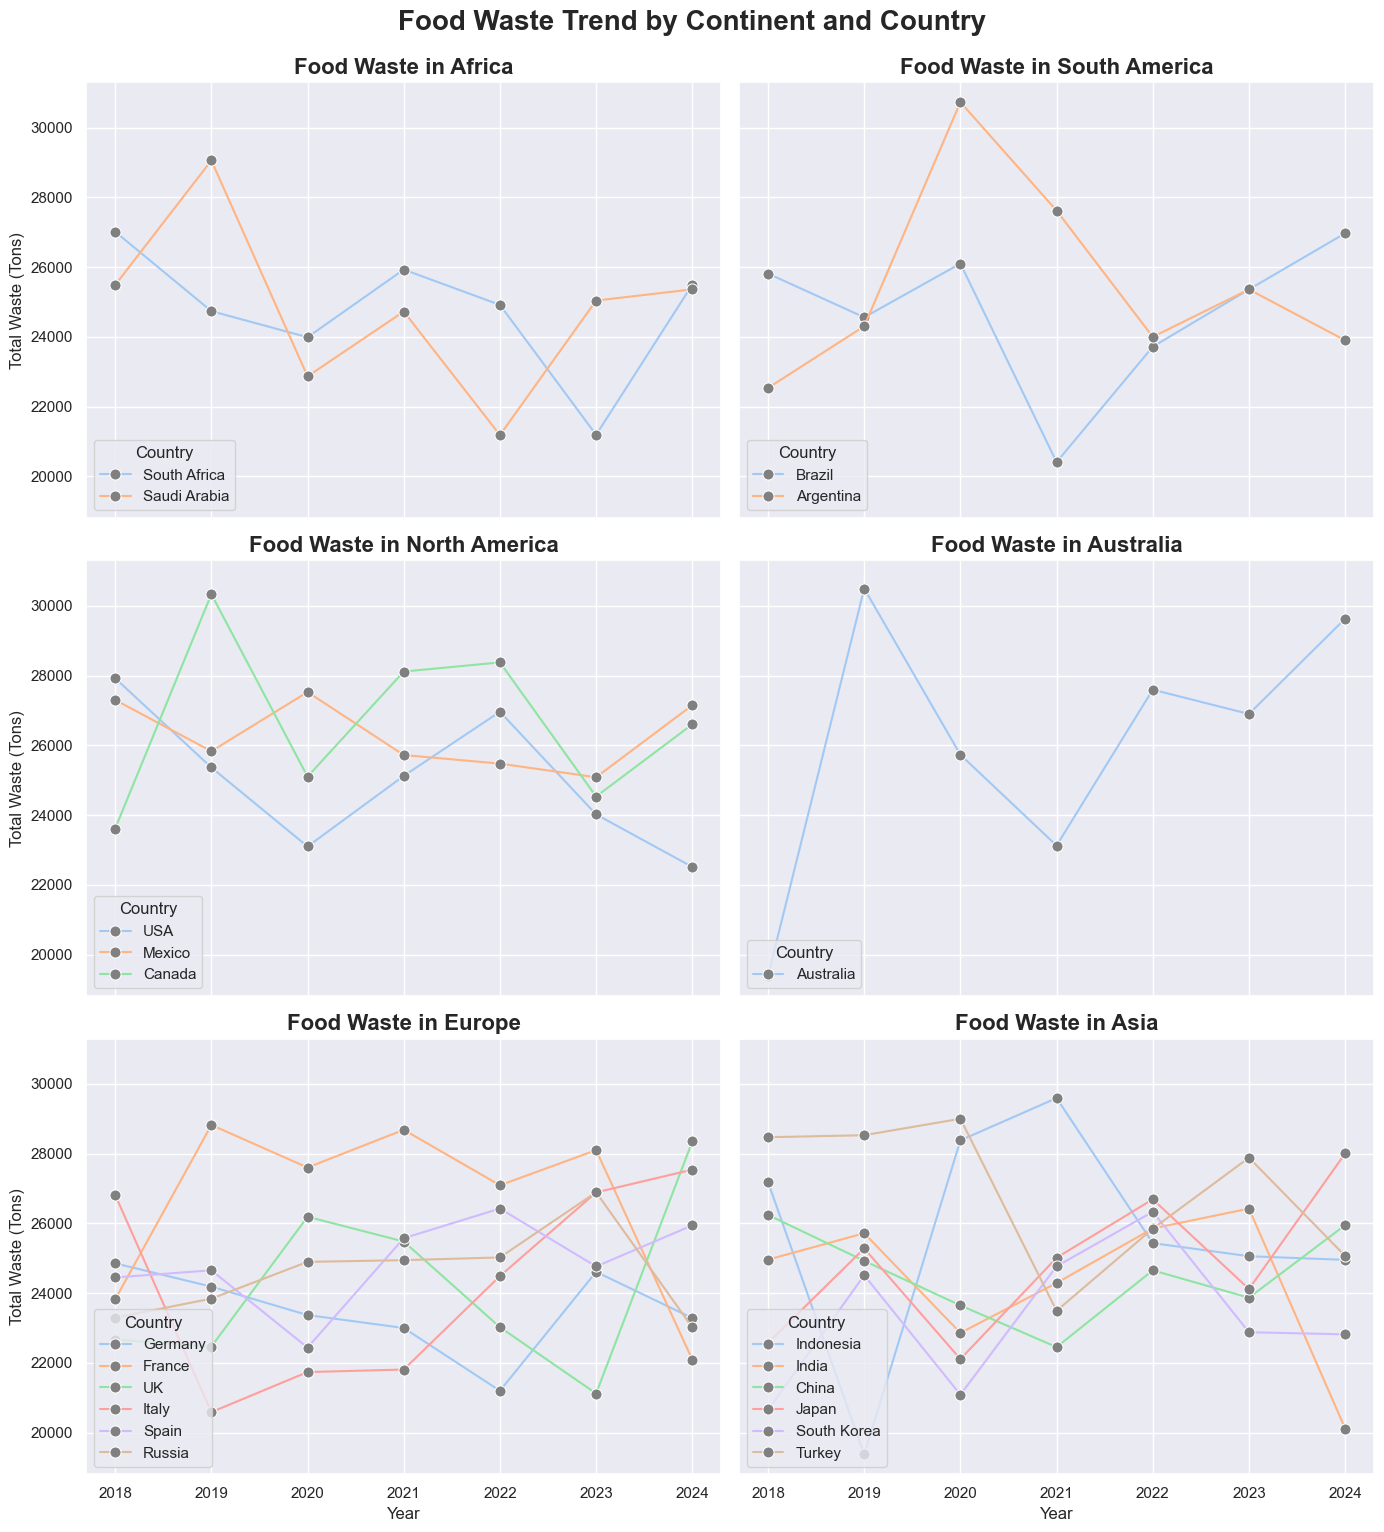

In [16]:
fig, axes = plt.subplots((len(world) + 1) // 2, 2, figsize=(14, (len(world) + 1) // 2 * 5), sharex=True, sharey=True)
for ax, continent in zip(axes.flatten(), world.items()):
    sns.lineplot(
        data=df[df['country'].isin(continent[1])],
        x='year',
        y='total_waste_tons',
        marker='o',
        markersize=8,
        markerfacecolor='grey',
        palette='pastel',
        estimator='mean',
        hue='country',
        ax=ax,
        errorbar=None
    ).legend(title="Country", loc='lower left')
    ax.set_title(f"Food Waste in {continent[0]}", fontsize=16, weight='bold')
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Waste (Tons)")
    ax.tick_params(axis='x')

plt.tight_layout()
plt.suptitle("Food Waste Trend by Continent and Country", fontsize=20, weight='bold', y=1.02)
plt.show()

### Next we will look at Food Wastage in countries of Europe and Asia more closely

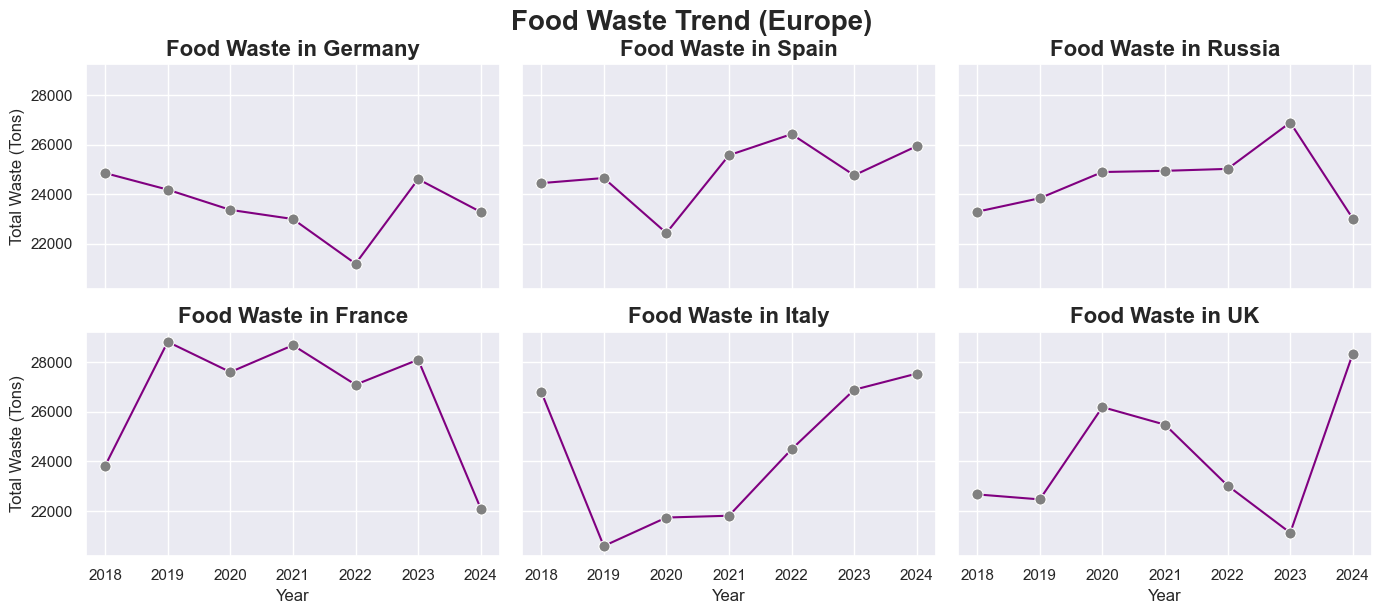

In [17]:
fig, axes = plt.subplots((len(europe) + 1) // 3, 3, figsize=(14, (len(europe) + 1) // 3 * 3), sharex=True, sharey=True)
for ax, country in zip(axes.flatten(), europe):
    sns.lineplot(
        data=df[df['country'] == country],
        x='year',
        y='total_waste_tons',
        marker='o',
        markersize=8,
        markerfacecolor='grey',
        color='purple',
        ax=ax,
        errorbar=None
    )
    ax.set_title(f"Food Waste in {country}", fontsize=16, weight='bold')
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Waste (Tons)")
    ax.tick_params(axis='x')

plt.tight_layout()
plt.suptitle("Food Waste Trend (Europe)", fontsize=20, weight='bold', y=1.02)
plt.show()


The trend lines are very different

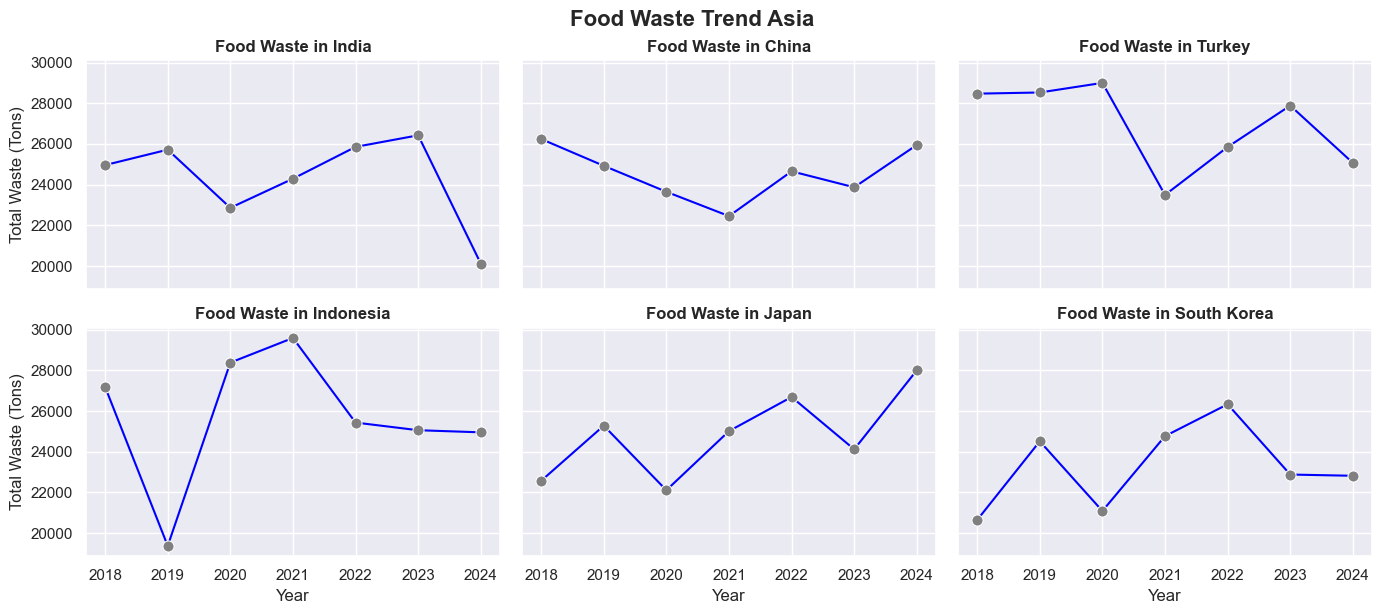

In [18]:
fig, axes = plt.subplots((len(asia) + 1) // 3, 3, figsize=(14, (len(asia) + 1) // 3 * 3), sharex=True, sharey=True)
for ax, country in zip(axes.flatten(), asia):
    sns.lineplot(
        data=df[df['country'] == country],
        x='year',
        y='total_waste_tons',
        marker='o',
        markersize=8,
        markerfacecolor='grey',
        color='blue',
        ax=ax,
        errorbar=None
    )
    ax.set_title(f"Food Waste in {country}", fontsize=12, weight='bold')
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Waste (Tons)")
    ax.tick_params(axis='x')

plt.tight_layout()
plt.suptitle("Food Waste Trend Asia", fontsize=16, weight='bold', y=1.02)
plt.show()


Trend lines of Japan and South Korea are quite similar, although Japan's food waste has gone up in 2024

### Economic Loss and Food Waste by Category

In [19]:
unique_cat = df['food_category'].unique()
cat_amount = df['food_category'].value_counts()
print('Food Categories:', unique_cat)
print('Amount of each Category:', cat_amount)

Food Categories: ['Fruits & Vegetables' 'Prepared Food' 'Dairy Products' 'Beverages'
 'Meat & Seafood' 'Grains & Cereals' 'Frozen Food' 'Bakery Items']
Amount of each Category: food_category
Prepared Food          711
Beverages              639
Bakery Items           630
Fruits & Vegetables    620
Dairy Products         616
Meat & Seafood         605
Frozen Food            596
Grains & Cereals       583
Name: count, dtype: int64


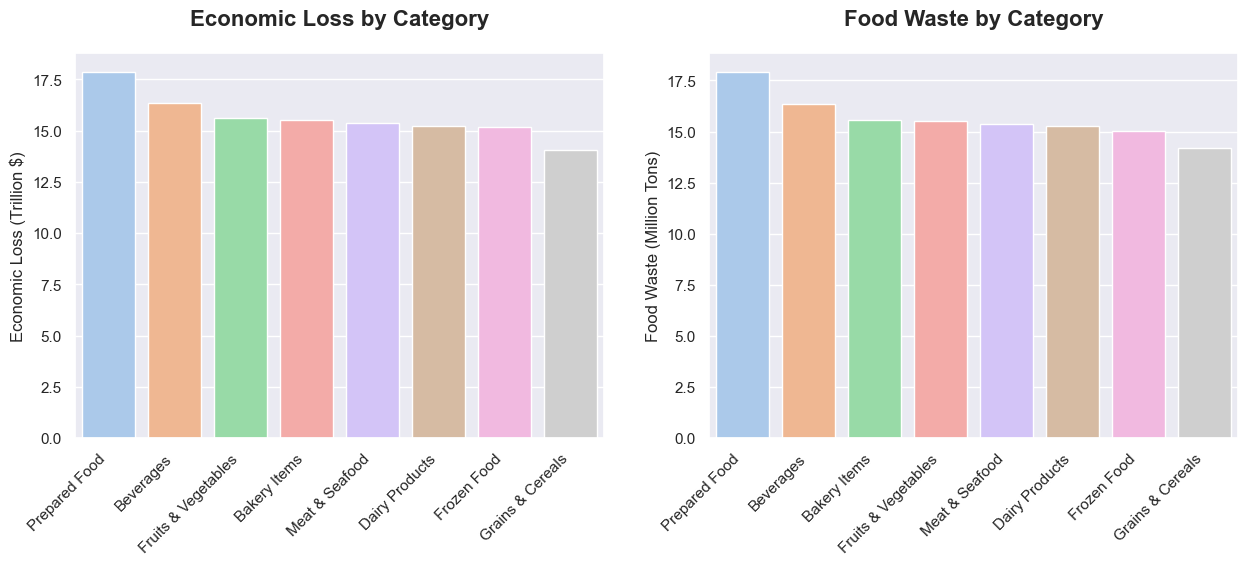

In [20]:
df_category_loss = pd.DataFrame(df.groupby('food_category')['economic_loss_million_'].sum()) / 1000000
df_category_loss = df_category_loss.sort_values(by='economic_loss_million_', ascending=False)

df_category_waste = pd.DataFrame(df.groupby('food_category')['total_waste_tons'].sum()) / 1000000
df_category_waste = df_category_waste.sort_values(by='total_waste_tons', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.barplot(df_category_loss,
            y="economic_loss_million_",
            ax=axes[0],
            x="food_category",
            hue='food_category',
            palette='pastel').set(
    title='Economic Loss by Category',
    xlabel='', 
    ylabel='Economic Loss (Trillion $)'
)
axes[0].set_title('Economic Loss by Category',  pad=20, fontsize=16, fontweight ="bold") 
ticks = axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), rotation=45, ha='right')

sns.barplot(df_category_waste,
            y="total_waste_tons",
            x="food_category",
            ax=axes[1],
            hue='food_category',
            palette='pastel').set(
    title='Food Waste by Category',
    xlabel='', 
    ylabel='Food Waste (Million Tons)'
)
axes[1].set_title('Food Waste by Category',  pad=20, fontsize=16, fontweight ="bold") 
ticks = axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation=45, ha='right')

Again, the plots are very similar, but Fruit & Veg fall behind Bakery Items in Food Waste, as opposed to Economic Loss, which indicates Fruit & Veg are more expensive per the same weight

### Economic Loss and Food Waste by Country

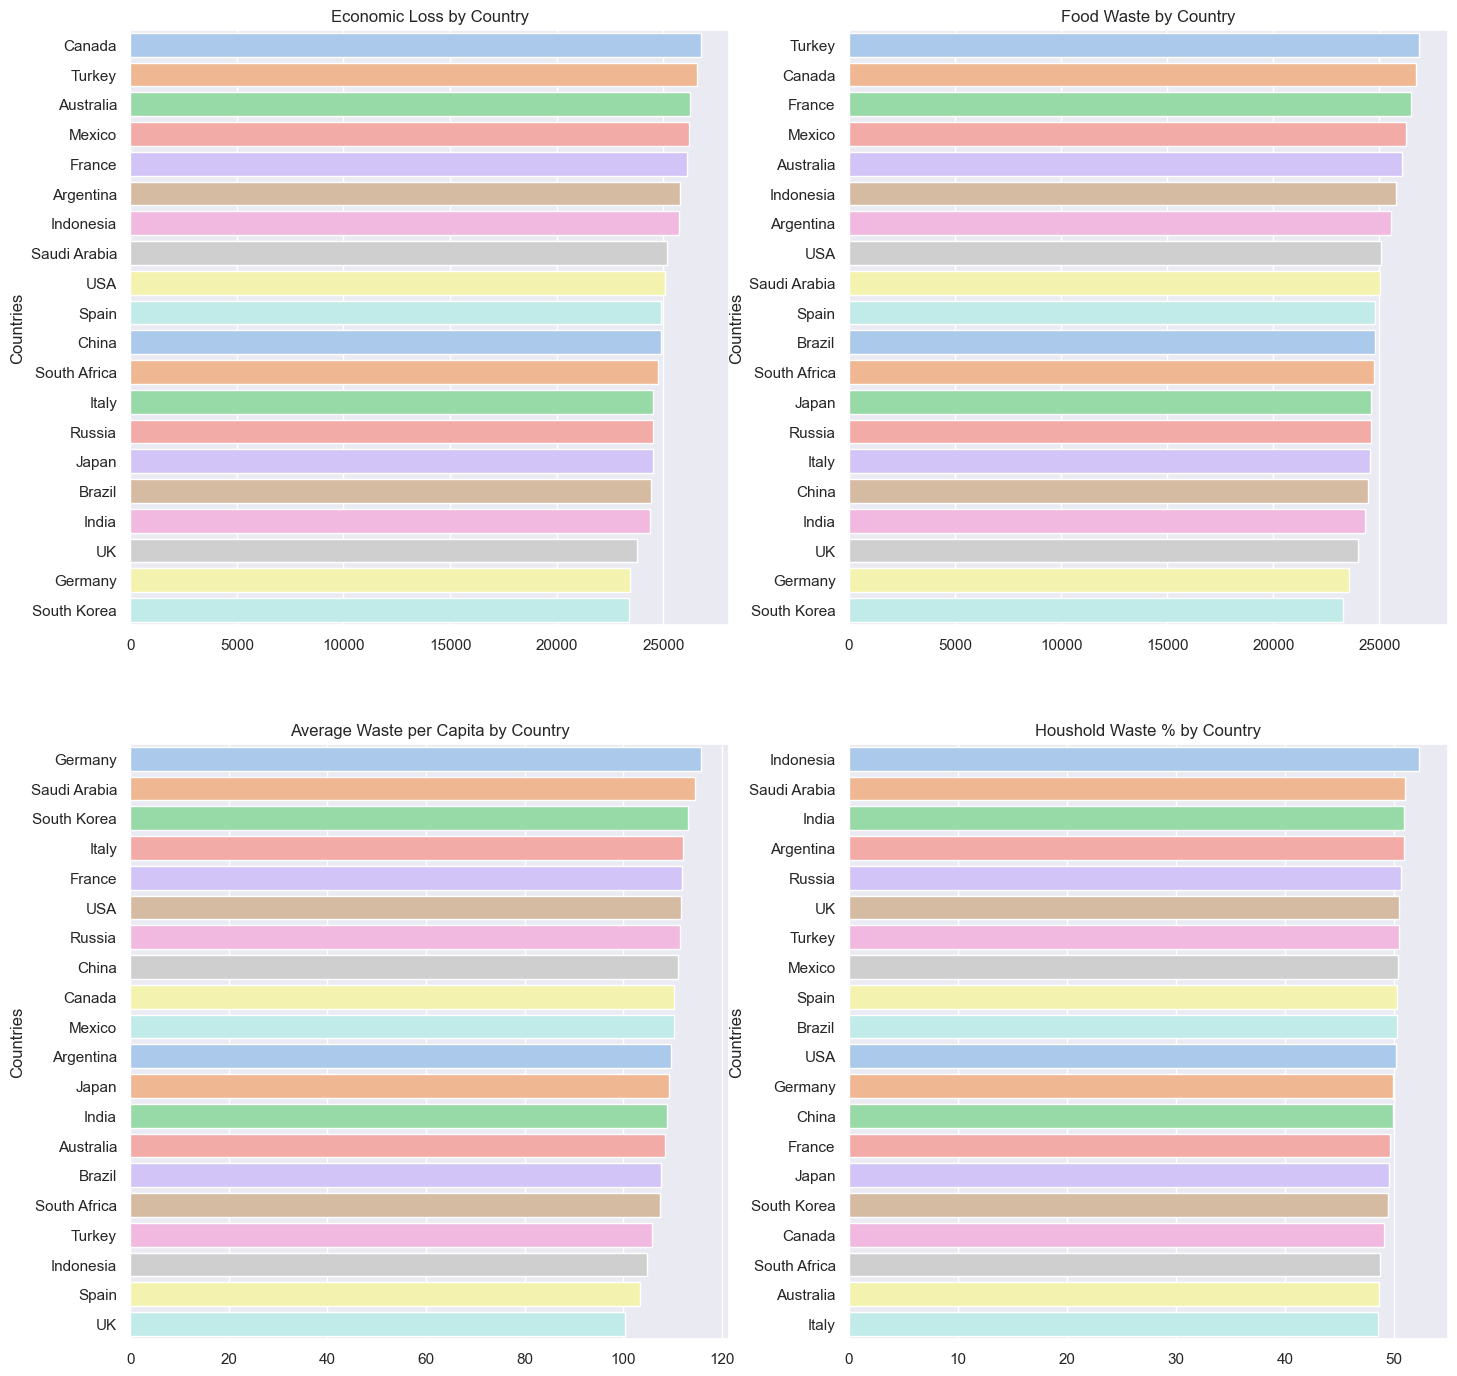

In [21]:
fid,axes = plt.subplots(2, 2, figsize=(17,17))

df_country_loss = pd.DataFrame(df.groupby('country')['economic_loss_million_'].mean())
df_country_loss = df_country_loss.sort_values(by='economic_loss_million_', ascending=False)
sns.barplot(df_country_loss,
            ax=axes[0, 0],
            x="economic_loss_million_",
            y="country",
            hue='country',
            palette='pastel').set(
    title='Economic Loss by Country',
    ylabel='Countries', 
    xlabel=''
)
ticks = plt.xticks()

df_country_waste = pd.DataFrame(df.groupby('country')['total_waste_tons'].mean())
df_country_waste = df_country_waste.sort_values(by='total_waste_tons', ascending=False)
sns.barplot(df_country_waste,
            ax=axes[0, 1],
            x="total_waste_tons",
            y="country",
            hue='country',
            palette='pastel').set(
    title='Food Waste by Country',
    ylabel='Countries', 
    xlabel=''
)
ticks = plt.xticks()

df_country_capita = pd.DataFrame(df.groupby('country')['avg_waste_per_capita_kg'].mean())
df_country_capita = df_country_capita.sort_values(by='avg_waste_per_capita_kg', ascending=False)
sns.barplot(df_country_capita,
            ax=axes[1, 0],
            x="avg_waste_per_capita_kg",
            y="country",
            hue='country',
            palette='pastel').set(
    title='Average Waste per Capita by Country',
    ylabel='Countries', 
    xlabel=''
)
ticks = plt.xticks()

df_country_household = pd.DataFrame(df.groupby('country')['household_waste_%'].mean())
df_country_household = df_country_household.sort_values(by='household_waste_%', ascending=False)
sns.barplot(df_country_household,
            ax=axes[1, 1],
            x="household_waste_%",
            y="country",
            hue='country',
            palette='pastel').set(
    title='Houshold Waste % by Country',
    ylabel='Countries', 
    xlabel=''
)
ticks = plt.xticks()

**Canada Turkey, Mexico, France** and **Australia** are in the **top 5** by Food Waste and Economic Loss.

Although **Germany** and **South Korea** have the lowest Econoomic Loss and Food Wastage, they are in **top 3** by Average waste per Capita 

Household Waste % does not seem to have a relationship with other charts, with **Indonesia, Saudi Arabia, India, Argentina** and **Russia** in **top 5**

 ### Merge a GDP per Capita Dataset

[GDP data](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD) was obtained from the World Bank Open Data portal and used under the CC BY 4.0 license

There is no data available for year 2024

In [23]:
gdp_df = pd.read_csv('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_19346.csv', skiprows=4) # download dataset and specify path

gdp_df = gdp_df[['Country Name', '2018', '2019', '2020', '2021', '2022', '2023']]

gdp = gdp_df[gdp_df['Country Name'].isin(countries)]
amount_not_incl = len(countries) - gdp.shape[0] # 5

countries_not_incl = set(countries) - set(gdp['Country Name'].unique()) # Turkey South Korea USA UK Russia

gdp_df[gdp_df['Country Name'].str.contains("Korea")] # South Korea - Korea, Rep. 126
gdp_df[gdp_df['Country Name'].str.contains("Tur")]  # Turkey- Turkiye 244
gdp_df[gdp_df['Country Name'].str.contains("United")] # USA - United States 251, UK- United Kingdom 81
gdp_df[gdp_df['Country Name'].str.contains("Russian")] # Russia - Russian Federation 202

add_countries = gdp_df.iloc[[126,244,251,81,202]]

name_map = {
    'United States': 'USA',
    'Russian Federation': 'Russia',
    'Korea, Rep.' : 'South Korea',
    'United Kingdom': 'UK',
    'Turkiye': 'Turkey'
}
add_countries['Country Name'] = add_countries['Country Name'].replace(name_map)
gdp = pd.concat([gdp, add_countries])

gdp = gdp.rename(columns={'Country Name': 'country'})
len(countries) - gdp.shape[0] # 0

C:\Users\Artur\AppData\Local\Temp\ipykernel_7072\3217209150.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_countries['Country Name'] = add_countries['Country Name'].replace(name_map)


0

Turn GDP dataset wrom wide format to long

In [24]:
gdp_long = gdp.melt(
    id_vars=['country'],   
    var_name='year',             
    value_name='gdp_per_capita'     
)
gdp_long['year'] = gdp_long['year'].astype(int)

Merge datasets

In [25]:
merged_df = df.merge(
    gdp_long,
    on=['country', 'year'],
    how='left'
)
merged_df.head()

,country,year,food_category,total_waste_tons,economic_loss_million_,avg_waste_per_capita_kg,population_million,household_waste_%,gdp_per_capita
0,Australia,2019,Fruits & Vegetables,19268.63,18686.68,72.69,87.59,53.64,54972.701789
1,Indonesia,2019,Prepared Food,3916.97,4394.48,192.52,1153.99,30.61,4106.948562
2,Germany,2022,Dairy Products,9700.16,8909.16,166.94,1006.11,48.08,49686.115458
3,France,2023,Fruits & Vegetables,46299.69,40551.22,120.19,953.05,31.91,44690.934540
4,France,2023,Beverages,33096.57,36980.82,104.74,1105.47,36.06,44690.934540


Let's calculate **Waste Per Capita to GDP per Capita ratio** for future use

In [26]:
merged_df['waste_gdp_ratio'] = merged_df['avg_waste_per_capita_kg'] / merged_df['gdp_per_capita']

In [27]:
gdp_grouped = merged_df.groupby(['year', 'country'], as_index=False)[['economic_loss_million_','gdp_per_capita', 'avg_waste_per_capita_kg', 'waste_gdp_ratio']].mean()

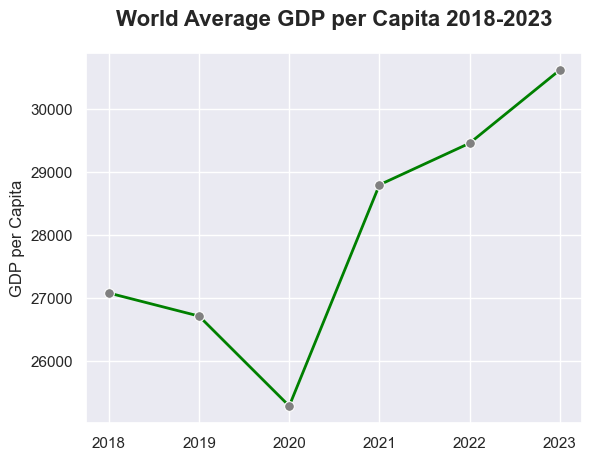

In [28]:
sns.lineplot(gdp_grouped, x='year', 
             errorbar=None,
             y='gdp_per_capita', color='green', markerfacecolor='grey', markersize=7,
            marker='o', linewidth=2).set(
    xlabel='', 
    ylabel='GDP per Capita'
)
plt.title('World Average GDP per Capita 2018-2023', fontsize=16, weight='bold', pad=20)
ticks = plt.xticks()

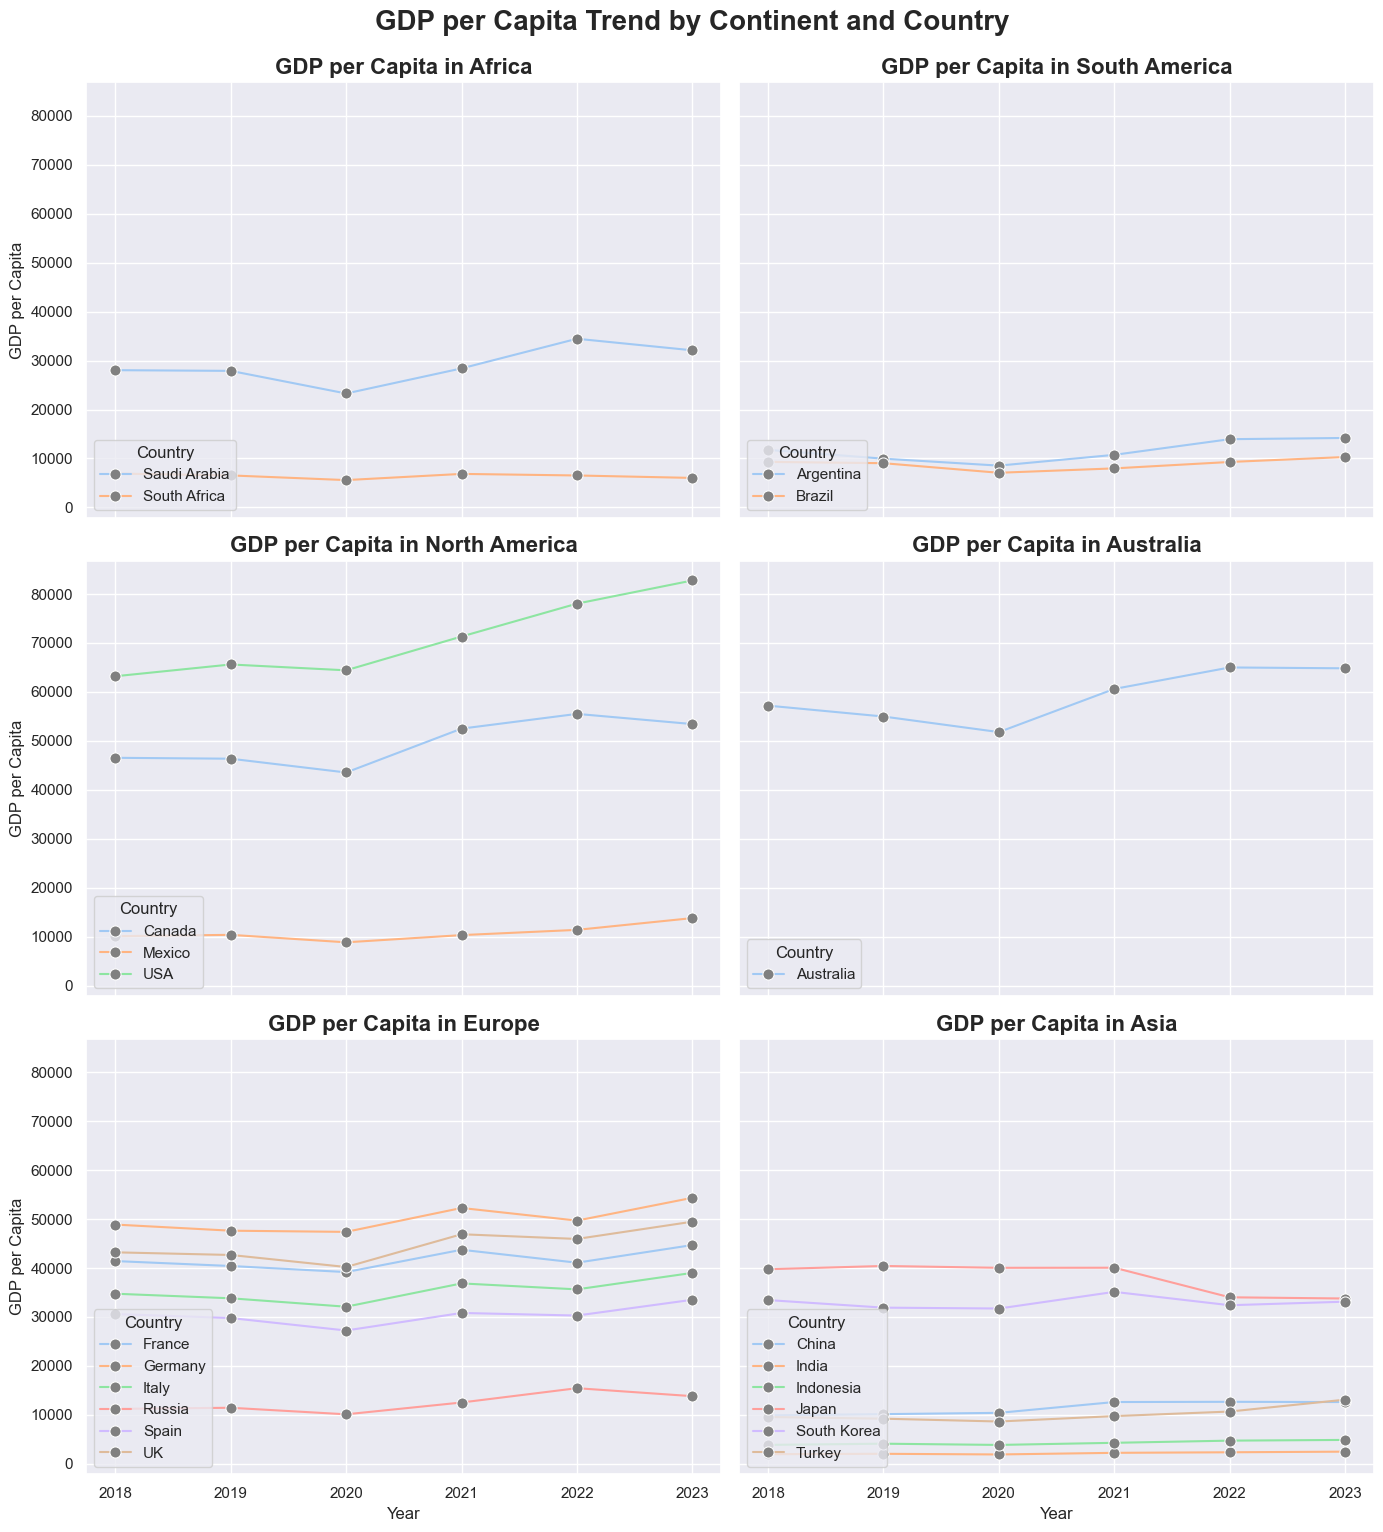

In [29]:
fig, axes = plt.subplots((len(world) + 1) // 2, 2, figsize=(14, (len(world) + 1) // 2 * 5), sharex=True, sharey=True)
for ax, continent in zip(axes.flatten(), world.items()):
    sns.lineplot(
        data=gdp_grouped[gdp_grouped['country'].isin(continent[1])],
        x='year',
        y='gdp_per_capita',
        marker='o',
        markersize=8,
        markerfacecolor='grey',
        palette='pastel',
        estimator='mean',
        hue='country',
        ax=ax,
        errorbar=None
    ).legend(title="Country", loc='lower left')
    ax.set_title(f"GDP per Capita in {continent[0]}", fontsize=16, weight='bold')
    ax.set_xlabel("Year")
    ax.set_ylabel("GDP per Capita")
    ax.tick_params(axis='x')

plt.tight_layout()
plt.suptitle("GDP per Capita Trend by Continent and Country", fontsize=20, weight='bold', y=1.02)
plt.show()

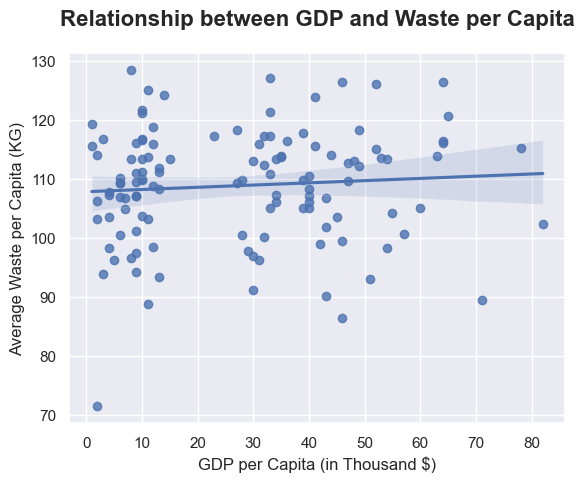

In [30]:
merged_df[['gdp_per_capita', 'avg_waste_per_capita_kg']].corr()
sns.regplot(data=gdp_grouped, x=gdp_grouped["gdp_per_capita"]//1000, y="avg_waste_per_capita_kg").set(
    xlabel='GDP per Capita (in Thousand $)', 
    ylabel='Average Waste per Capita (KG)'
)
plt.title('Relationship between GDP and Waste per Capita', fontsize=16, weight='bold', pad=20)
ticks = plt.xticks()

Average waste and GDP per Capita do not seem to be correlated

In [31]:
def classify_income(gdp):
    if gdp <= 1135:
        return 'Low'
    elif gdp <= 4465:
        return 'Lower-Middle'
    elif gdp <= 13845:
        return 'Upper-Middle'
    elif gdp > 13845:
        return 'High'

gdp_grouped['income_group'] = gdp_grouped['gdp_per_capita'].apply(classify_income)
merged_df['income_group'] = merged_df['gdp_per_capita'].apply(classify_income)

Income groups defined using **World Bank thresholds** for **2023**, based on GNI per capita

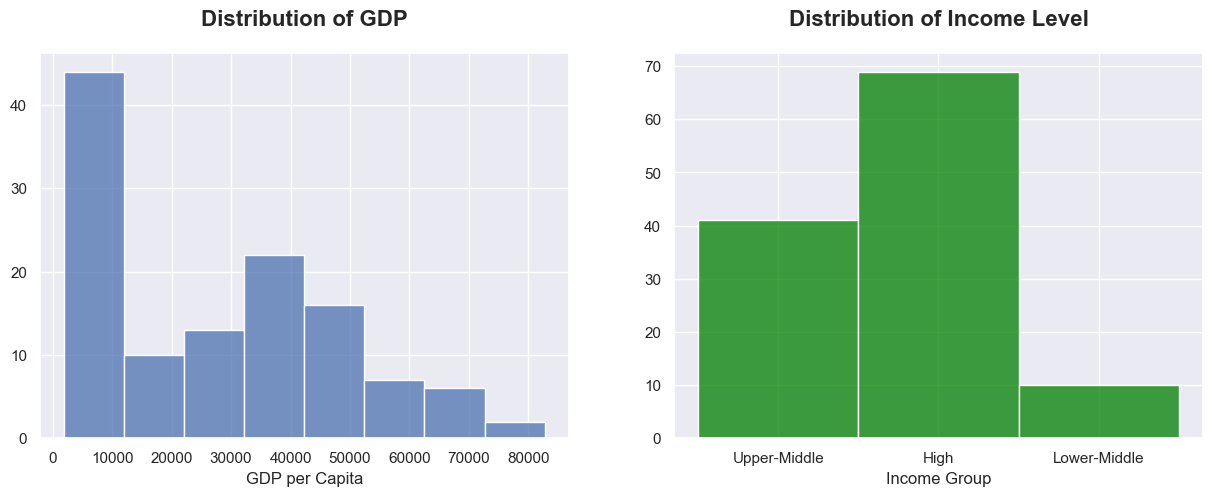

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(data=gdp_grouped, x="gdp_per_capita", ax=axes[0]).set(
    xlabel='GDP per Capita', 
    ylabel=''
)
axes[0].set_title('Distribution of GDP',  pad=20, fontsize=16, fontweight ="bold") 
ticks = plt.xticks()

sns.histplot(data=gdp_grouped, color='green', x="income_group", ax=axes[1]).set(
    xlabel='Income Group', 
    ylabel=''
)
axes[1].set_title('Distribution of Income Level',  pad=20, fontsize=16, fontweight ="bold") 
ticks = plt.xticks()

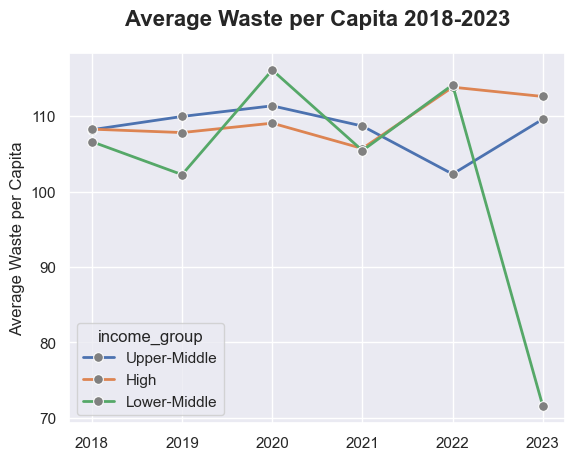

In [33]:
sns.lineplot(gdp_grouped[gdp_grouped['year'] != 2024], # because we don't have income data for 2024
             x='year', 
             errorbar=None,
             y='avg_waste_per_capita_kg', color='green',
             hue='income_group', 
             markerfacecolor='grey', markersize=7,
            marker='o', linewidth=2).set(
    xlabel='', 
    ylabel='Average Waste per Capita'
)
plt.title('Average Waste per Capita 2018-2023', fontsize=16, weight='bold', pad=20)
ticks = plt.xticks()

Let's investigate a huge drop in waste in Lower-Middle group

In [34]:
gdp_grouped[(gdp_grouped['year'].isin(range(2021,2024))) & (gdp_grouped['income_group'] == 'Lower-Middle')]

,year,country,economic_loss_million_,gdp_per_capita,avg_waste_per_capita_kg,waste_gdp_ratio,income_group
67,2021,India,24168.364074,2239.613844,103.157037,0.046060,Lower-Middle
68,2021,Indonesia,29499.722424,4287.173140,107.737576,0.025130,Lower-Middle
87,2022,India,25332.803056,2352.613925,114.160833,0.048525,Lower-Middle
107,2023,India,25744.018710,2480.792087,71.570968,0.028850,Lower-Middle


It looks like **Indonesia** transitioned into a different income group in 2022

**India** is the only country in Lower-Middle income group in 2022 and 2023

Lets look at other countries' income group over time

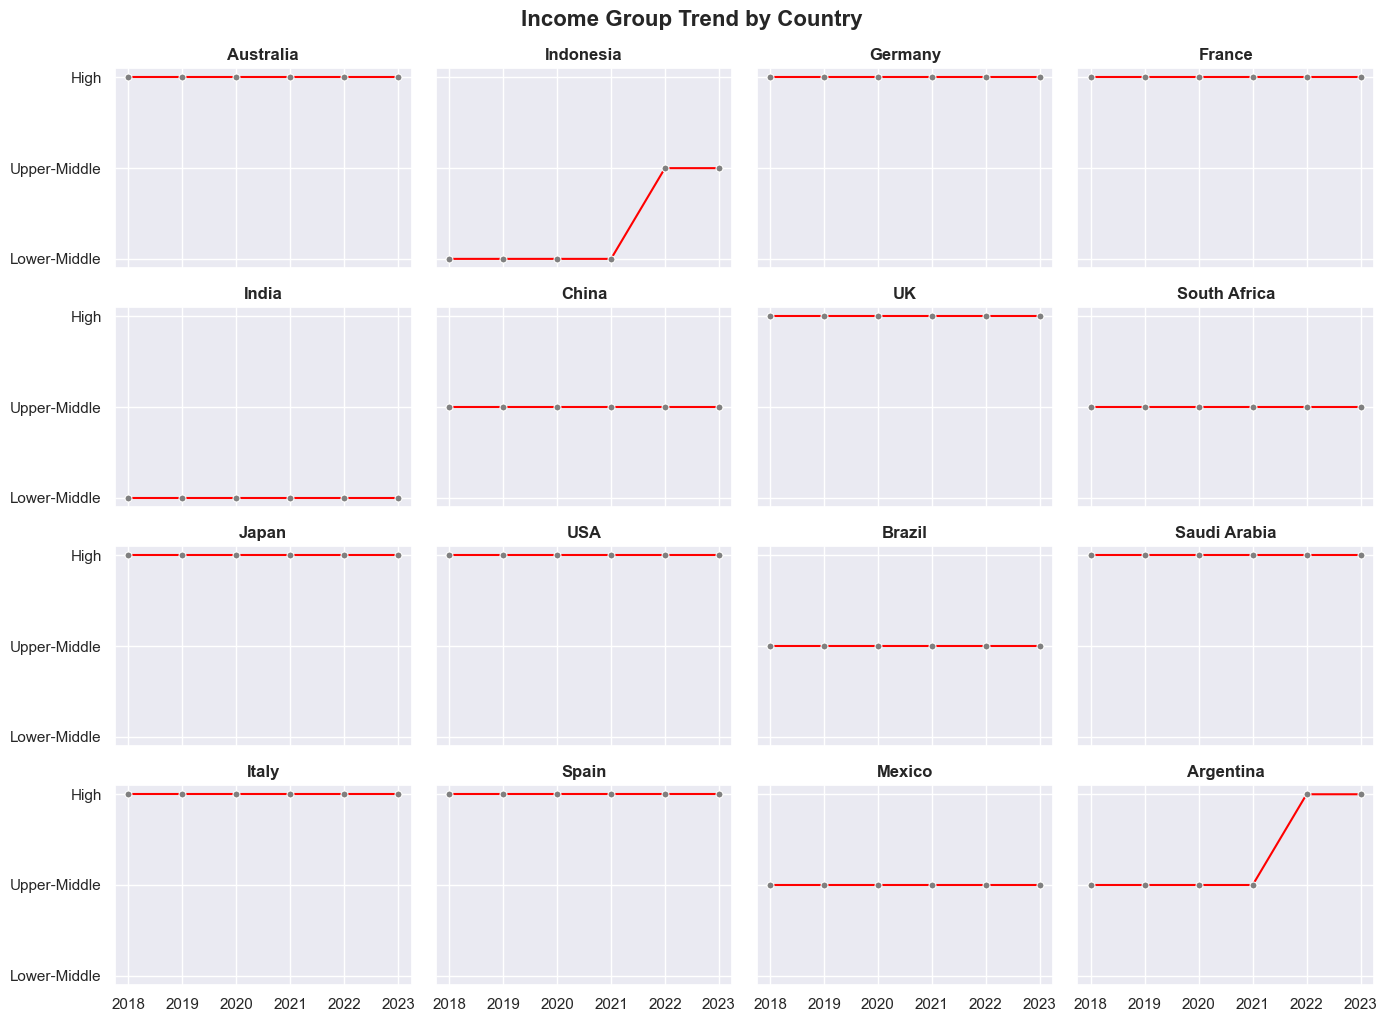

In [35]:
fig, axes = plt.subplots((len(countries) + 1) // 5, 4, figsize=(14, 10), sharex=True, sharey=True)

income_order = ['High', 'Upper-Middle','Lower-Middle', 'Low Income' ]

sorted_income = gdp_grouped
sorted_income['income_group'] = pd.Categorical(
    sorted_income['income_group'],
    categories=income_order,
    ordered=True
)

for ax, country in zip(axes.flatten(), countries):
    sns.lineplot(
        data=sorted_income[sorted_income['country'] == country],
        x='year',
        y='income_group',
        marker='o',
        markersize=5,
        markerfacecolor='grey',
        color='red',
        ax=ax,
        errorbar=None
    )
    ax.set_title(f"{country}", fontsize=12, weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x')

plt.tight_layout()
plt.suptitle("Income Group Trend by Country", fontsize=16, weight='bold', y=1.02)
plt.show()


**Indonesia** transitioned into **Upper-Middle** income group in 2022

**Argentina** also went up in GDP per capita, coming into **High Income** group in 2022

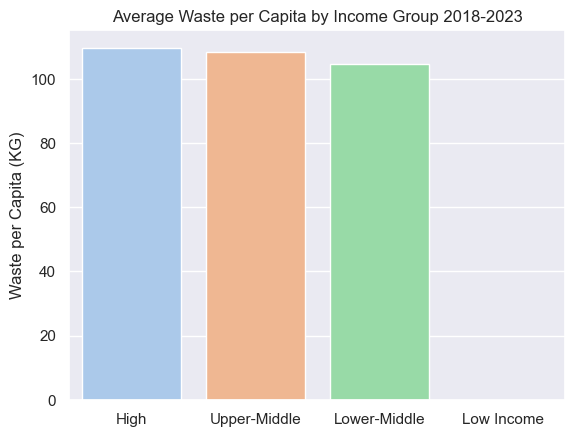

In [36]:
income_grouped = gdp_grouped.groupby('income_group', as_index=False, observed=False)['avg_waste_per_capita_kg'].mean()

sns.barplot(income_grouped,
            x="income_group",
            y="avg_waste_per_capita_kg",
            hue='income_group',
            palette='pastel').set(
    title='Average Waste per Capita by Income Group 2018-2023',
    ylabel='Waste per Capita (KG)', 
    xlabel=''
)
ticks = plt.xticks()

Again, the **waste** does **not** seem to be significantly **dependent** on the **income** group

Now, we will check if there is any **correlation** between **Waste to GDP ratio** and **income**

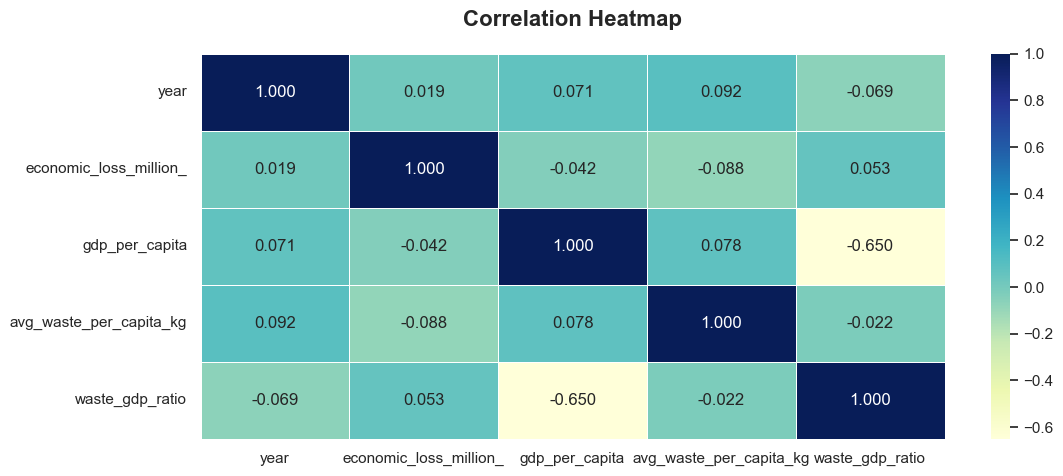

In [37]:
plt.figure(figsize=(12,5))
sns.heatmap(
    gdp_grouped.corr(numeric_only=True), 
    annot=True, 
    cmap='YlGnBu', 
    fmt='.3f', 
    linewidths=0.5
)
plt.title("Correlation Heatmap", fontsize=16, weight='bold', pad=20)
plt.show()

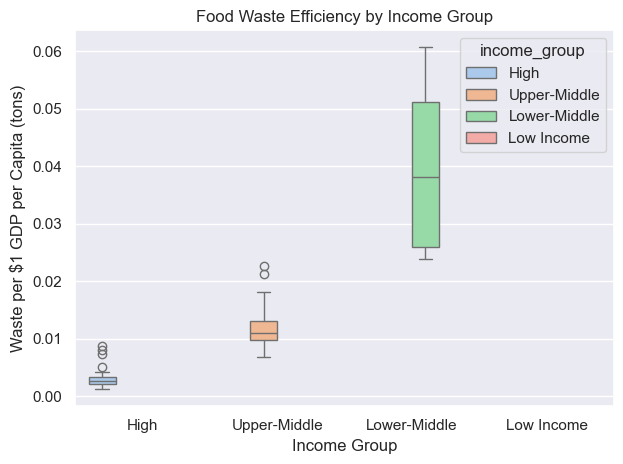

In [38]:
sns.boxplot(
    data=gdp_grouped,
    x='income_group',
    y='waste_gdp_ratio',
    hue='income_group',
    palette='pastel'
)

plt.title('Food Waste Efficiency by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Waste per $1 GDP per Capita (tons)')
plt.tight_layout()
plt.show()

As we can see, there is a clear inverse relationship between income group and food waste per unit of GDP per capita. 
This suggests that higher-income countries may have more efficient food systems or stronger waste management infrastructure

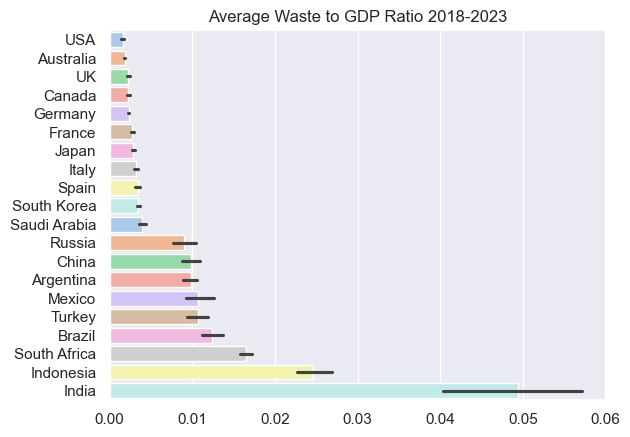

In [39]:
sns.barplot(gdp_grouped.sort_values(by='waste_gdp_ratio'),
            x="waste_gdp_ratio",
            y="country",
            hue='country',
            palette='pastel').set(
    title='Average Waste to GDP Ratio 2018-2023',
    ylabel='', 
    xlabel=''
)
ticks = plt.xticks()

**USA, Australia, UK, Canada, Germany** arre top-5 most waste efficient countries

Top-5 least waste efficient countries are **India, Indonesia, South Africa, Brazil, Turkey**

### Predicting Economic Loss

In [40]:
x = merged_df[['food_category', 'total_waste_tons', 
               'avg_waste_per_capita_kg', 'waste_gdp_ratio']]

y = merged_df['economic_loss_million_']

In [41]:
x_num= x.select_dtypes(include=['int64', 'float64']).columns
x_cat = x.select_dtypes(include=['object']).columns

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), 
    ('scaler', StandardScaler())
])

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, x_num),
    ('ohe_p', ohe_pipeline, x_cat)
    ],
    remainder='passthrough', 
    n_jobs=-1)
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=25)
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [43]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_preprocessed, y_train)
rf.score(X_train_preprocessed, y_train)

0.9921023557238957

In [44]:
y_pred = rf.predict(X_test_preprocessed)

In [45]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 2770.478530500001
R2 Score: 0.9384766315664674


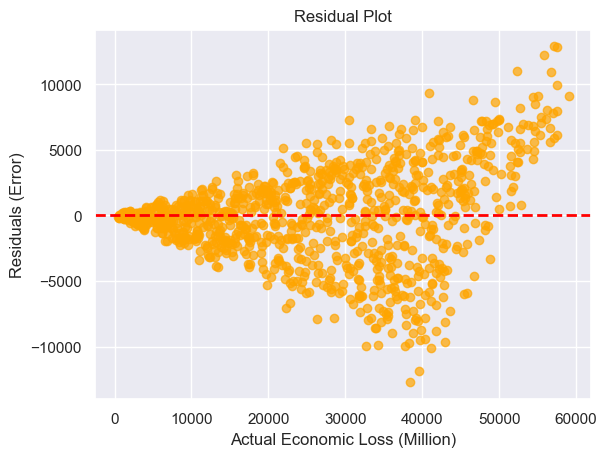

In [46]:
plt.scatter(y_test, 
            y_test - y_pred, 
            color='orange', 
            alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Economic Loss (Million)")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

The higher the loss the greater the error

Now, we can create predictions for the whole dataset

In [47]:
X_preprocessed = pipeline.transform(x)
rf.fit(X_preprocessed, y)
y_pred_final = rf.predict(X_preprocessed)
merged_df['predicted_loss'] = y_pred_final

### What if total waste reduced by 10%?

In [48]:
merged_df['total_waste_10_reduced'] = merged_df['total_waste_tons'] * 0.9
x_reduced = x
x_reduced['total_waste_tons'] = merged_df['total_waste_10_reduced']
X_preprocessed_reduced = pipeline.transform(x_reduced)
y_pred_reduced = rf.predict(X_preprocessed_reduced)
merged_df['predicted_loss_reduced'] = y_pred_reduced
merged_df.head()

C:\Users\Artur\AppData\Local\Temp\ipykernel_7072\2293915044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_reduced['total_waste_tons'] = merged_df['total_waste_10_reduced']


,country,year,food_category,total_waste_tons,economic_loss_million_,avg_waste_per_capita_kg,population_million,household_waste_%,gdp_per_capita,waste_gdp_ratio,income_group,predicted_loss,total_waste_10_reduced,predicted_loss_reduced
0,Australia,2019,Fruits & Vegetables,19268.63,18686.68,72.69,87.59,53.64,54972.701789,0.001322,High,18853.0022,17341.767,17733.7786
1,Indonesia,2019,Prepared Food,3916.97,4394.48,192.52,1153.99,30.61,4106.948562,0.046877,Lower-Middle,4158.5779,3525.273,3333.5429
2,Germany,2022,Dairy Products,9700.16,8909.16,166.94,1006.11,48.08,49686.115458,0.003360,High,9211.2207,8730.144,9574.2050
3,France,2023,Fruits & Vegetables,46299.69,40551.22,120.19,953.05,31.91,44690.934540,0.002689,High,42915.1688,41669.721,44733.4531
4,France,2023,Beverages,33096.57,36980.82,104.74,1105.47,36.06,44690.934540,0.002344,High,36490.0947,29786.913,31210.6718


In [49]:
savings_country = merged_df.groupby(['country', 'year']).agg({
    'economic_loss_million_': 'sum',
    'total_waste_10_reduced': 'sum',
    'total_waste_tons': 'sum',
    'predicted_loss': 'sum',
    'predicted_loss_reduced': 'sum'
}).reset_index()

savings_country[['economic_loss_billion',
                 'waste_reduced_1000_tons',
                 'waste_1000_tons',
                 'pred_loss_billion',
                 'pred_loss_reduced_billion'
                ]] = savings_country[[
    'economic_loss_million_',
    'total_waste_10_reduced', 
    'total_waste_tons', 
    'predicted_loss',
    'predicted_loss_reduced'
]] / 1000
savings_country = savings_country.drop(columns=[
    'economic_loss_million_',
    'total_waste_10_reduced', 
    'total_waste_tons', 
    'predicted_loss',
    'predicted_loss_reduced'
])

savings_country['saved_food_1000_tons'] = (
    (savings_country['waste_1000_tons'] - savings_country['waste_reduced_1000_tons'])
)
savings_country['saved_loss_billion'] = (
   (savings_country['pred_loss_billion'] - savings_country['pred_loss_reduced_billion'])
)

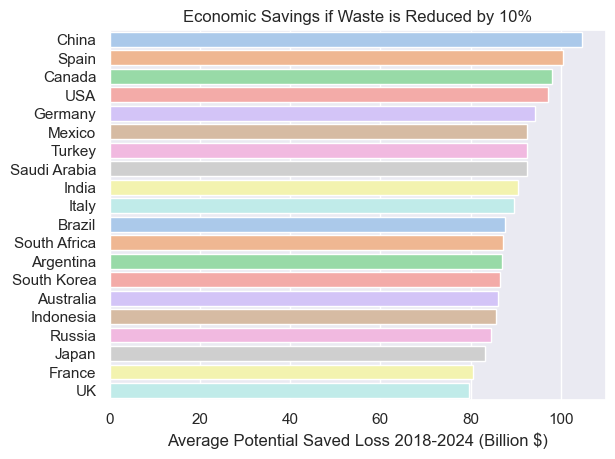

In [50]:
country_sorted = savings_country.groupby('country', as_index=False)['saved_loss_billion'].mean().reset_index()
country_sorted = country_sorted.sort_values(by='saved_loss_billion', ascending=False)
sns.barplot(country_sorted,
            x="saved_loss_billion",
            y="country",
            hue='country',
            palette='pastel',
            errorbar=None).set(
    title='Economic Savings if Waste is Reduced by 10%',
    ylabel='', 
    xlabel='Average Potential Saved Loss 2018-2024 (Billion $)'
)
ticks = plt.xticks()

**Top 6** countries that could benefit the most from waste reduction are:
**China, Spain, Canada, USA, Saudi Arabia, Germany**

Let's compare actual and predicted losses for these countries

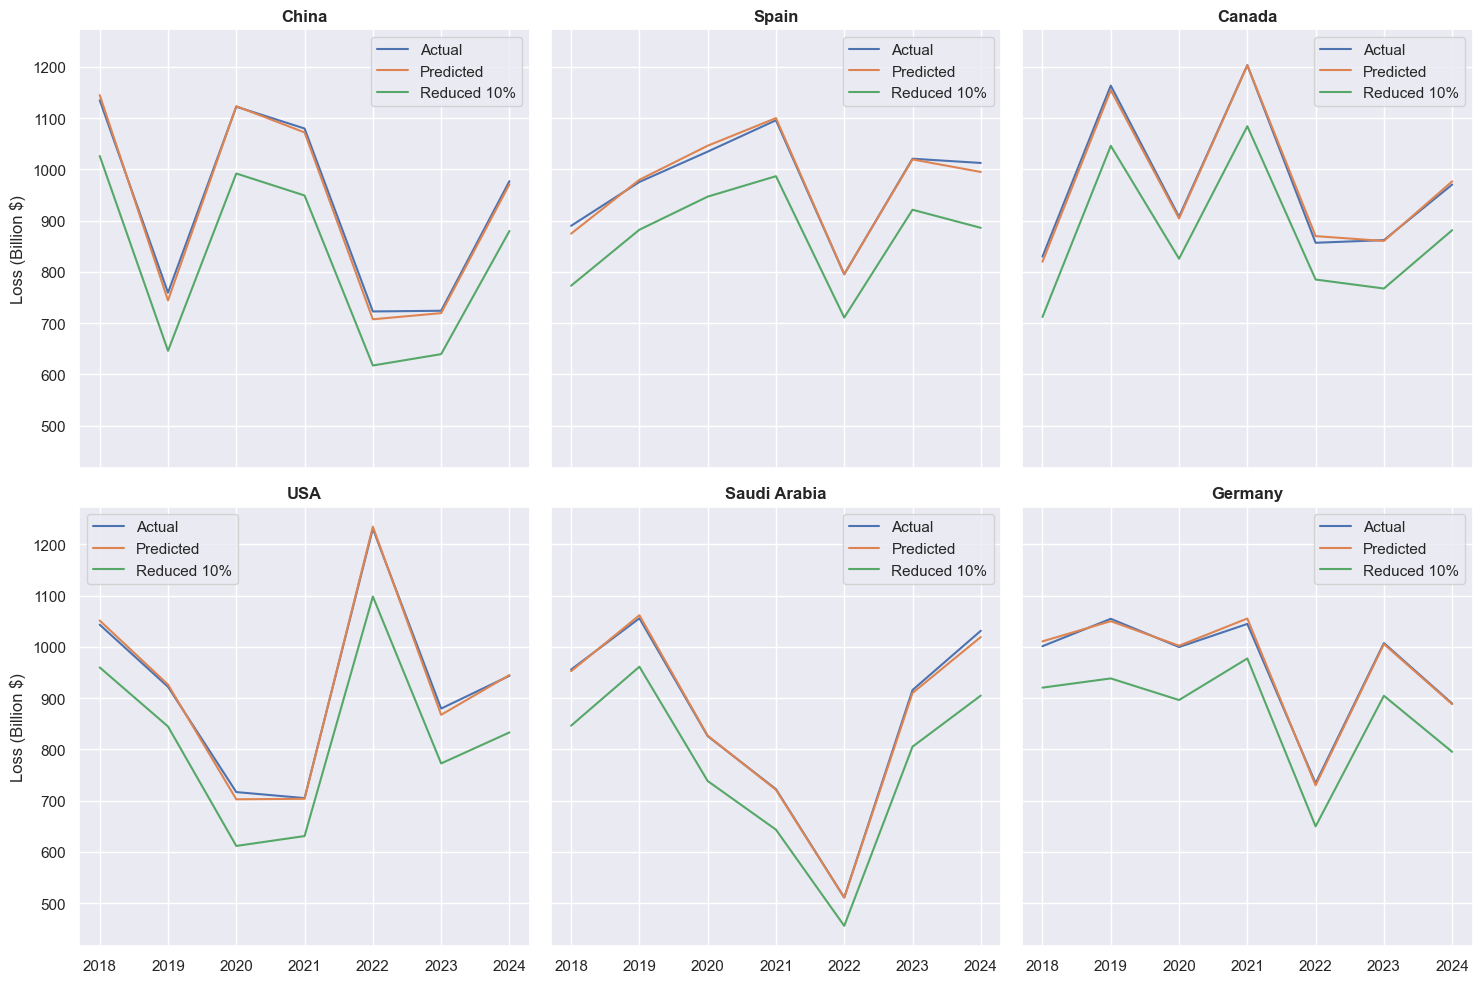

In [51]:
top_5 = ['China', 'Spain', 'Canada', 'USA', 'Saudi Arabia', 'Germany']

fig, axes = plt.subplots(2, 3, figsize=(15,10), sharey=True, sharex=True)
for ax, country in zip(axes.flatten(), top_5):
    sns.lineplot(ax=ax,data=savings_country[savings_country['country'] == country], 
                 errorbar=None, x='year', y=savings_country['economic_loss_billion'], label='Actual')
    sns.lineplot(ax=ax,data=savings_country[savings_country['country'] == country], 
                 errorbar=None, x='year', y=savings_country['pred_loss_billion'], label='Predicted')
    sns.lineplot(ax=ax,data=savings_country[savings_country['country'] == country], 
                 errorbar=None, x='year', y=savings_country['pred_loss_reduced_billion'], label='Reduced 10%')
    ax.set_title(f"{country}", fontsize=12, weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Loss (Billion $)")
plt.tight_layout()
   

If countries reduced food waste by just 10%, there would have been a huge economic benefit

### Evaluate Potential Savings %

In [52]:
savings_year = savings_country.groupby('year', as_index=False)[['saved_food_1000_tons', 'saved_loss_billion']].sum()
savings_year[['saved_food_million_tons', 'saved_loss_trillion']] = savings_year[['saved_food_1000_tons', 'saved_loss_billion']]/1000
savings_year = savings_year.drop(columns=['saved_loss_billion', 'saved_food_1000_tons'])

savings_year['food_savings_pct'] = savings_year['saved_food_million_tons'] / savings_year['saved_food_million_tons'].iloc[0] * 100
savings_year['money_savings_pct'] = savings_year['saved_loss_trillion'] / savings_year['saved_loss_trillion'].iloc[0] * 100


savings_year_melted = savings_year.melt(
    id_vars=['year'],
    value_vars=['food_savings_pct', 'money_savings_pct'],
    var_name='type',
    value_name='saved'
)

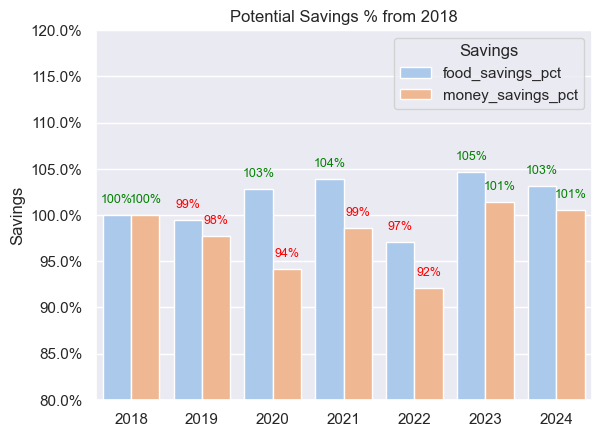

In [53]:
import matplotlib.ticker as mtick

fig,ax = plt.subplots()

sns.barplot(data=savings_year_melted, 
            ax=ax,
            x='year',
            y='saved',
            hue='type',
            palette='pastel').set(
    title='Potential Savings % from 2018',
    xlabel='',
    ylabel='Savings')

plt.legend(title='Savings')
ax.set_ylim(80,120)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        color = 'green' if height >= 100 else 'red'
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,
            f'{height:.0f}%',
            ha='center',
            va='bottom',
            color=color,
            fontsize=9
        )

The most money and food could have been saved in **2023**

In [54]:
savings_food_cat = merged_df.groupby(['food_category']).agg({
    'economic_loss_million_': 'sum',
    'total_waste_10_reduced': 'sum',
    'total_waste_tons': 'sum',
    'predicted_loss': 'sum',
    'predicted_loss_reduced': 'sum'
}).reset_index()

savings_food_cat[['economic_loss_billion',
                 'waste_reduced_1000_tons',
                 'waste_1000_tons',
                 'pred_loss_billion',
                 'pred_loss_reduced_billion'
                ]] = savings_food_cat[[
    'economic_loss_million_',
    'total_waste_10_reduced', 
    'total_waste_tons', 
    'predicted_loss',
    'predicted_loss_reduced'
]] / 1000
savings_food_cat = savings_food_cat.drop(columns=[
    'economic_loss_million_',
    'total_waste_10_reduced', 
    'total_waste_tons', 
    'predicted_loss',
    'predicted_loss_reduced'
])

savings_food_cat['saved_food_1000_tons'] = (
    (savings_food_cat['waste_1000_tons'] - savings_food_cat['waste_reduced_1000_tons'])
)
savings_food_cat['saved_loss_billion'] = (
   (savings_food_cat['pred_loss_billion'] - savings_food_cat['pred_loss_reduced_billion'])
)

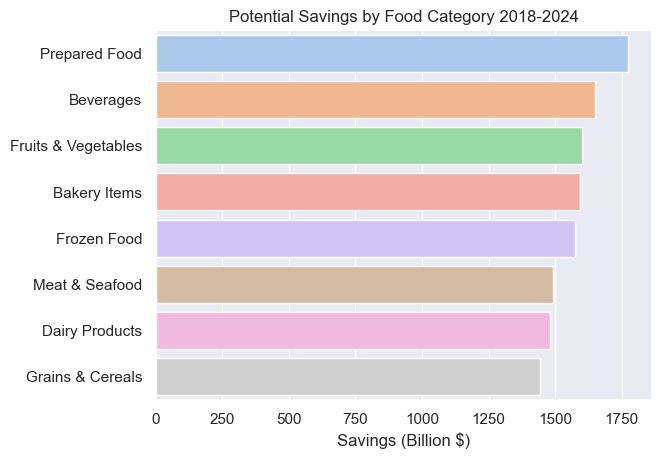

In [55]:
sns.barplot(savings_food_cat.sort_values(by='saved_loss_billion', ascending=False),
            x="saved_loss_billion",
            y="food_category",
            hue='food_category',
            palette='pastel',
            errorbar=None).set(
    title='Potential Savings by Food Category 2018-2024',
    ylabel='', 
    xlabel='Savings (Billion $)'
)
ticks = plt.xticks()

**1.75 trillion $** could have been saved over the years **2018-2024** if **10% less prepared food** was wasted

### Conclusion

- Food waste and economic loss are highly correlated globally.
- Countries like **Canada, Turkey, Mexico, France, and Australia** consistently rank high in both waste and loss.
- **Fruit & Veg** waste causes more economic loss per unit than **Bakery Items**, highlighting their higher value.
- **Germany and South Korea** have low total waste but high per capita rates.
- **Higher income = more efficient food systems** — income group is inversely related to waste per unit of GDP.
- **Top waste-efficient countries**: USA, Australia, UK, Canada, Germany.  
  **Least efficient**: India, Indonesia, South Africa, Brazil, Turkey.
- Reducing prepared food waste by just **10%** from 2018–2024 could’ve saved **$1.75 trillion**.
- **Biggest potential savers**: China, Spain, Canada, USA, Saudi Arabia, Germany.

Reducing food waste isn't just good for the planet — it's a massive economic opportunity.

### Thank you!

Veronika Shevchenko